In [ ]:
# %load tokenizer.py
import os
import json
import re
import spacy
from collections import defaultdict, Counter

class BPETokenizer:
    def __init__(self, path=".datas/merges_bpe.json", num_merges=1000, dataset=None):
        self.path = path
        self.num_merges = num_merges
        self.merges = None
        self.nlp = spacy.load("fr_core_news_sm")

        if dataset is not None:
            self.learn_merges(dataset)
        elif os.path.exists(self.path):
            self._load_merges()

    def preprocess_sentence(self, sentence):
        doc = self.nlp(sentence.lower())
        tokens = [token.lemma_ for token in doc if token.is_alpha]
        return " ".join(tokens)

    def _get_vocab(self, corpus):
        vocab = defaultdict(int)
        for sentence in corpus:
            words = sentence.lower().split()
            for word in words:
                chars = list(word) + ['</w>']
                vocab[tuple(chars)] += 1
        return vocab

    def _get_stats(self, vocab):
        pairs = defaultdict(int)
        for word, freq in vocab.items():
            for i in range(len(word)-1):
                pairs[(word[i], word[i+1])] += freq
        return pairs

    def _merge_vocab(self, pair, vocab):
        new_vocab = {}
        bigram = pair
        replacement = ''.join(bigram)
        for word, freq in vocab.items():
            new_word = []
            i = 0
            while i < len(word):
                if i < len(word)-1 and word[i] == bigram[0] and word[i+1] == bigram[1]:
                    new_word.append(replacement)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_vocab[tuple(new_word)] = freq
        return new_vocab

    def learn_merges(self, dataset):
        print("Apprentissage des merges BPE...")
        preprocessed = [self.preprocess_sentence(s) for s in dataset]
        vocab = self._get_vocab(preprocessed)
        merges = []

        for i in range(self.num_merges):
            pairs = self._get_stats(vocab)
            if not pairs:
                break
            best = max(pairs, key=pairs.get)
            vocab = self._merge_vocab(best, vocab)
            merges.append(best)

        self.merges = merges
        self._save_merges()
        print(f"{len(merges)} merges appris et saved.")

    def _apply_bpe_to_word(self, word):
        word = list(word) + ["</w>"]
        for merge in self.merges:
            i = 0
            while i < len(word) - 1:
                if word[i] == merge[0] and word[i + 1] == merge[1]:
                    word[i:i + 2] = ["".join(merge)]
                else:
                    i += 1
        return word

    def _load_merges(self):
        with open(self.path, "r", encoding="utf-8") as f:
            merges = json.load(f)
        self.merges = [tuple(pair) for pair in merges]

    def _save_merges(self):
        os.makedirs(os.path.dirname(self.path), exist_ok=True)
        with open(self.path, "w", encoding="utf-8") as f:
            json.dump(self.merges, f, ensure_ascii=False, indent=2)

    def _clean_text(self, text):
        text = text.lower()
        text = re.sub(r"[^\w\s']", " ", text)  # garder les apostrophes
        text = re.sub(r"\s+", " ", text).strip()
        return text

    def tokenize(self, text):
        text = self.preprocess_sentence(text)
        tokens = []
        for word in text.split():
            tokens.extend(self._apply_bpe_to_word(word))
        return tokens

    def __call__(self, text):
        return self.tokenize(text)


In [52]:
import os

def load_lyrics_dataset(root_folder="../lyrics_dataset"):
    data = []
    labels = []
    for epoch in os.listdir(root_folder):
        epoch_path = os.path.join(root_folder, epoch)
        if not os.path.isdir(epoch_path):
            continue
        for genre in os.listdir(epoch_path):
            genre_path = os.path.join(epoch_path, genre)
            for album in os.listdir(genre_path):
                album_path = os.path.join(genre_path, album)
                for filename in os.listdir(album_path):
                    if filename.endswith(".txt"):
                        with open(os.path.join(album_path, filename), "r", encoding="utf-8") as f:
                            lyrics = f.read()
                            data.append(lyrics)
                            labels.append(epoch)
    return data, labels


In [47]:
tokenizer = BPETokenizer()
print(tokenizer("Bonjour, le monde !"))


['B', 'on', 'jour', ',', '</w>', 'le</w>', 'monde</w>', '!', '</w>']


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


data, labels = load_lyrics_dataset()
X = [" ".join(tokenizer(lyrics)) for lyrics in data]



/Users/emre/Projects/IA/nlp-project-music/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emre/Projects/IA/nlp-project-music/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emre/Projects/IA/nlp-project-music/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

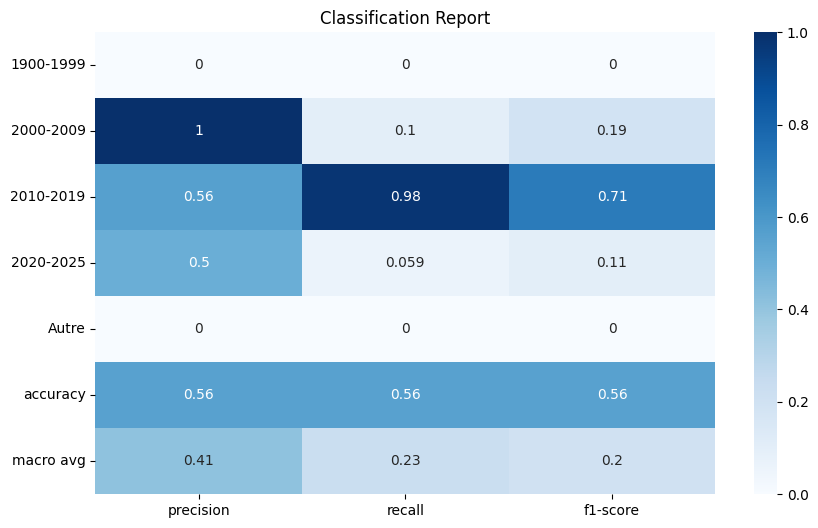

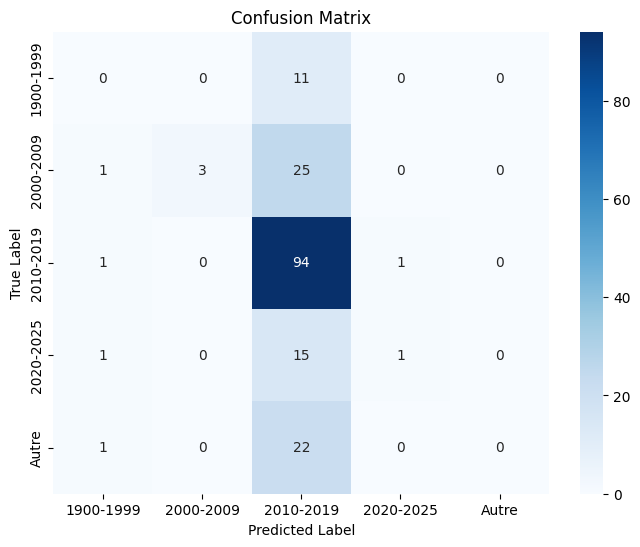

In [63]:
# Split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Vectorization TF-IDF
vectorizer = TfidfVectorizer(max_features=100)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Model - Random Forest for better performance
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_vec, y_train)

# Predictions
y_pred = model.predict(X_test_vec)

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
unique_labels = sorted(list(set(y_test) | set(y_pred)))
conf_matrix_df = pd.DataFrame(conf_matrix, index=unique_labels, columns=unique_labels)

# Plot Classification Report
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues")
plt.title("Classification Report")
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()



In [70]:
new_text = "Mon bokken brille le style de la mouette s'abat sur sa proie"

new_text_tok = " ".join(tokenizer(new_text))
new_text_vec = vectorizer.transform([new_text_tok])
predicted_label = model.predict(new_text_vec)
predicted_proba = model.predict_proba(new_text_vec)

print(f"Classe prédite : {predicted_label[0]}")
print(f"Probabilités : {predicted_proba[0]}")


Classe prédite : 2010-2019
Probabilités : [0.13  0.095 0.575 0.13  0.07 ]
